In [1]:
from sklearn.metrics import cohen_kappa_score
import json
import spacy
from tqdm import tqdm
import os
import re
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

### Inter-annotator agreement among human annotators

In [2]:
def annotations_to_bio(text, annotations):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    
    # Initialize BIO tags
    bio_tags = ['O'] * len(doc)
    
    for entity in annotations:
        label = entity['label']
        start = entity['start_offset']
        end = entity['end_offset']
        
        # Find tokens that overlap with the entity
        for token in doc:
            if start <= token.idx < end:
                if token.idx == start:
                    bio_tags[token.i] = 'B-' + label
                else:
                    bio_tags[token.i] = 'I-' + label
    
    # Combine tokens with BIO tags
    bio_format = []
    for token, tag in zip(doc, bio_tags):
        bio_format.append((tag, token.text))
    
    return bio_format

In [3]:
lalit_annotations = []
with open('/project_resources/private_workspace/naimish/de-id-annotations/inter-annotator-aggrement/lalit.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        bio_formatted = annotations_to_bio(data['text'], data['entities'])
        lalit_annotations.append([tuple[0] for tuple in bio_formatted])

In [4]:
vandana_annotations = []
with open('/project_resources/private_workspace/naimish/de-id-annotations/inter-annotator-aggrement/vandana.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        bio_formatted = annotations_to_bio(data['text'], data['entities'])
        vandana_annotations.append([tuple[0] for tuple in bio_formatted])

In [ ]:
lalit_annotations_flattened = [label for doc in lalit_annotations for label in doc]
vandana_annotations_flattened = [label for doc in vandana_annotations for label in doc]

# Calculate Cohen's Kappa
kappa = round(cohen_kappa_score(lalit_annotations_flattened , vandana_annotations_flattened),3)

print(f"Cohen's Kappa coefficient: {kappa}")

Cohen's Kappa coefficient: 0.921


### Inter-annotator agreement among physician (Discharge summaries classified into Real/Synthetic)

In [ ]:
labels_user1 = []
text_user1 = []
with open('/project_resources/private_workspace/naimish/user1.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        text_user1.append(data['text'])
        labels_user1.append(data['label'][0])
        
path_to_folders = "/project_resources/private_workspace/naimish/60_Sampled_discharge_summaries/Sampled_summaries/"
predicted_labels_user1 = {}
files = os.listdir(path_to_folders)
for file in files:
    file_name = os.path.join(path_to_folders, file)
    with open(file_name , 'r') as file:
        file_contents = file.read()
        predicted_labels_user1[file_name.split('/')[-1]] = labels_user1[text_user1.index(file_contents)]

In [ ]:
labels_user2 = []
text_user2 = []
with open('/project_resources/private_workspace/naimish/user2.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        text_user2.append(data['text'])
        labels_user2.append(data['label'][0])
        
path_to_folders = "/project_resources/private_workspace/naimish/60_Sampled_discharge_summaries/Sampled_summaries/"
predicted_labels_user2 = {}
files = os.listdir(path_to_folders)
for file in files:
    file_name = os.path.join(path_to_folders, file)
    with open(file_name , 'r') as file:
        file_contents = file.read()
        predicted_labels_user2[file_name.split('/')[-1]] = labels_user2[text_user2.index(file_contents)]

In [ ]:
kappa = round(cohen_kappa_score(list(dict(sorted(predicted_labels_user1.items())).values()),list(dict(sorted(predicted_labels_user2.items())).values())),3)
print(f"Cohen's kappa coefficient: {kappa}")

Cohen's kappa coefficient: 0.29


### Confusion matrix on convenience sample (60 discharge summaries) evaluated by physicians

In [ ]:
def name_extract(file_name):
    match = re.search(r'(\d+)', file_name)
    if match:
        extracted_int = int(match.group(1))
    else:
        print("No integer found in the file name.")
    return extracted_int

In [ ]:
actual_labels = {}
for file in files:
    file_name = os.path.join(path_to_folders, file)
    if (name_extract(file_name.split('/')[-1]) >= 1 and name_extract(file_name.split('/')[-1]) <= 15) or (name_extract(file_name.split('/')[-1]) >= 31 and name_extract(file_name.split('/')[-1]) <= 45):
        actual_labels[file_name.split('/')[-1]] = 'Synthetic'
    else:
        actual_labels[file_name.split('/')[-1]] = 'Real'

In [ ]:
actual = []
pred_labels_p1 = []
pred_labels_p2 = []
for file in files:
    actual.append(actual_labels[file])
    pred_labels_p1.append(predicted_labels_user1[file])
    pred_labels_p2.append(predicted_labels_user2[file])

For Physician 1

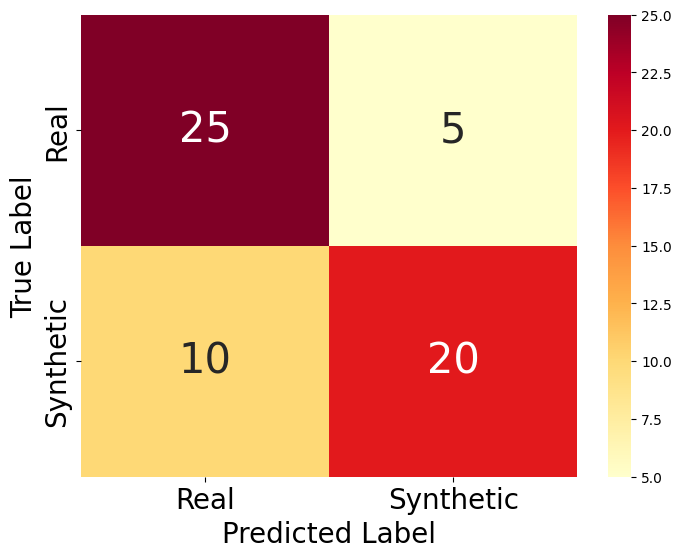

Precision: 0.714
Recall: 0.833
F1-score: 0.769


In [ ]:
actual_labels = actual
predicted_labels = pred_labels_p1

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=["Real", "Synthetic"])

# Plot the confusion matrix using seaborn with explicit class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=["Real", "Synthetic"], yticklabels=["Real", "Synthetic"], annot_kws={"fontsize": 30})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('figures/Physician1_Evaluation.pdf', bbox_inches='tight') 
plt.show()

precision = precision_score(actual_labels, predicted_labels, pos_label="Real")
recall = recall_score(actual_labels, predicted_labels, pos_label="Real")
f1 = f1_score(actual_labels, predicted_labels, pos_label="Real")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

For Physician 2

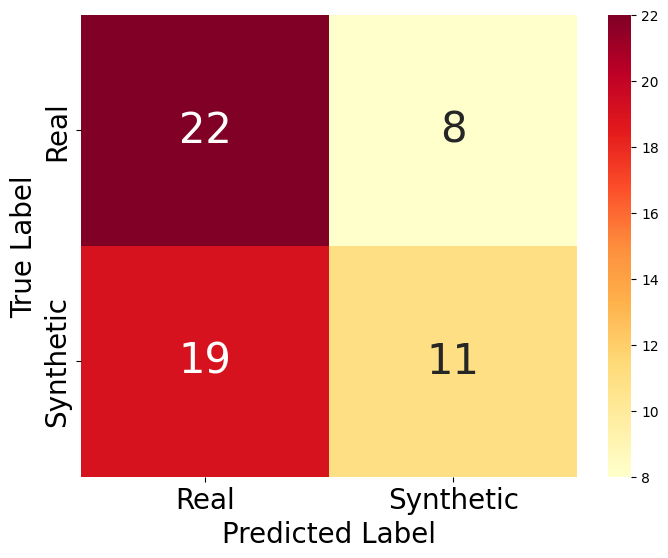

Precision: 0.537
Recall: 0.733
F1-score: 0.620


In [ ]:
actual_labels = actual
predicted_labels = pred_labels_p2

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=["Real", "Synthetic"])

# Plot the confusion matrix using seaborn with explicit class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=["Real", "Synthetic"], yticklabels=["Real", "Synthetic"], annot_kws={"fontsize": 30})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('figures/Physician2_Evaluation.pdf', bbox_inches='tight') 
plt.show()

precision = precision_score(actual_labels, predicted_labels, pos_label="Real")
recall = recall_score(actual_labels, predicted_labels, pos_label="Real")
f1 = f1_score(actual_labels, predicted_labels, pos_label="Real")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")